In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

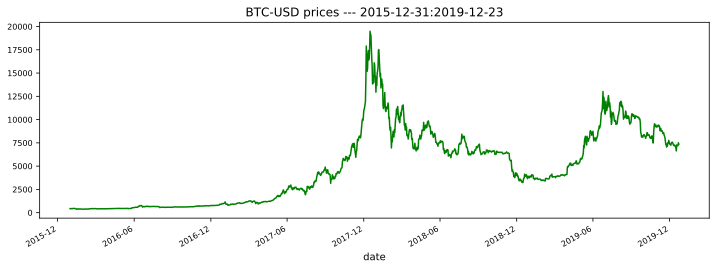

In [4]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/BTC.csv')

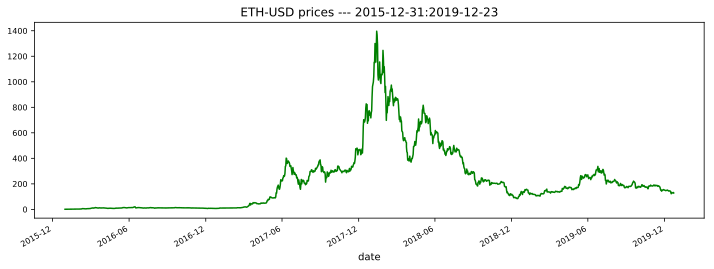

In [5]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/ETH.csv')

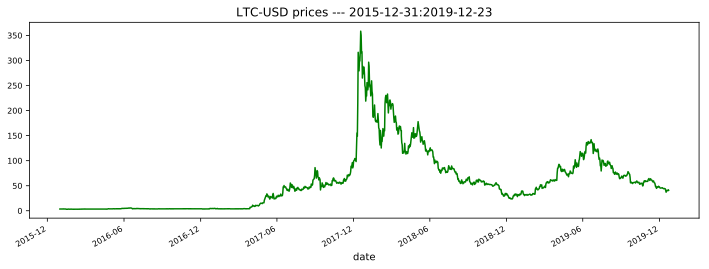

In [6]:
download_csv_data(ticker='LTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/LTC.csv')

In [7]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH', 'LTC']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [8]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                   open        close
date                                
2019-12-19  7202.844238  7202.844238
2019-12-20  7218.816406  7218.816406
2019-12-21  7191.158691  7191.158691
2019-12-22  7511.588867  7511.588867
2019-12-23  7355.628418  7355.628418
                  open       close
date                              
2019-12-19  129.321136  129.321136
2019-12-20  129.066055  129.066055
2019-12-21  128.130951  128.130951
2019-12-22  132.372513  132.372513
2019-12-23  128.614090  128.614090
                 open      close
date                            
2019-12-19  39.920296  39.920296
2019-12-20  40.290157  40.290157
2019-12-21  39.996830  39.996830
2019-12-22  41.965191  41.965191
2019-12-23  40.847473  40.847473


In [9]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 1454 (major_axis) x 2 (minor_axis)
Items axis: BTC to LTC
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-23 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [10]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

BTC       ETH       LTC
BTC  1.000000  0.760034  0.878331
ETH  0.760034  1.000000  0.903119
LTC  0.878331  0.903119  1.000000

# Построение границы эффективности

###  Задаем стартовые параметры

In [11]:
# set the number of combinations for imaginary portfolios
num_portfolios = 300
COMMISSION = 0.0007
DELTA = 0.4

### Определяем стартовые переменные

In [12]:
num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

#set random seed for reproduction's sake
np.random.seed(101)

In [13]:
for CASH in tqdm(range(1,30,1)):
    CASH = CASH/100
    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in tqdm(range(num_portfolios)):
        weights = np.random.random(num_assets)     # добавил "+1"  (учитывем еще и cash)
        weights /= np.sum(weights)/(1-CASH)
        WEIGHTS = weights  # добавил [0:-1]

        def initialize(context):

            context.set_commission(commission.PerDollar(cost=COMMISSION))

            #set_benchmark(symbol('BTC'))

            context.tikers = TIKERS
            context.assets = [context.symbol(symbol) for symbol in context.tikers]

            context.weights = WEIGHTS
            context.n_assets = len(context.assets)

            context.window = 1

            context.rebalance_count = 0
            context.time = 0


        def handle_data(context, data):

            if context.time == 0:

                # extract prices
                prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

                # submit orders
                for i, asset in enumerate(context.assets):
                    order_target_percent(asset, context.weights[i])

                context.time += 1

            else:
                for i, asset in enumerate(context.assets):
                    if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
                        order_target_percent(asset, context.weights[i])
                        context.rebalance_count += 1

                context.time += 1

        perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                      end=datetime(2019, 12, 20, 0, 0, 0, 0, pytz.utc),
                                      initialize=initialize,
                                      capital_base=100000000,
                                      #trading_calendar=AlwaysOpenCalendar(),
                                      handle_data=handle_data,
                                      data=panel)

        returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

        sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
        port_returns.append(qf.get_performance_summary(returns).annualized_returns)
        port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
        stock_weights.append(WEIGHTS)

100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [7:12:52<00:00, 895.60s/it]


# Визуализация результатов

In [15]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [18]:
df.to_csv('BTC-ETH-LTC-Cash_dinamic_reb247.csv')

In [19]:
df.tail()

Returns  Volatility  Sharpe Ratio  BTC Weight  ETH Weight  LTC Weight
8695  1.336570    0.570823      1.771147    0.450217    0.240818    0.018965
8696  1.322512    0.603643      1.695664    0.338297    0.295677    0.076027
8697  1.619294    0.655287      1.789112    0.219140    0.398145    0.092715
8698  1.119934    0.569795      1.600683    0.292312    0.134072    0.283616
8699  1.672507    0.758794      1.660274    0.052937    0.491954    0.165109

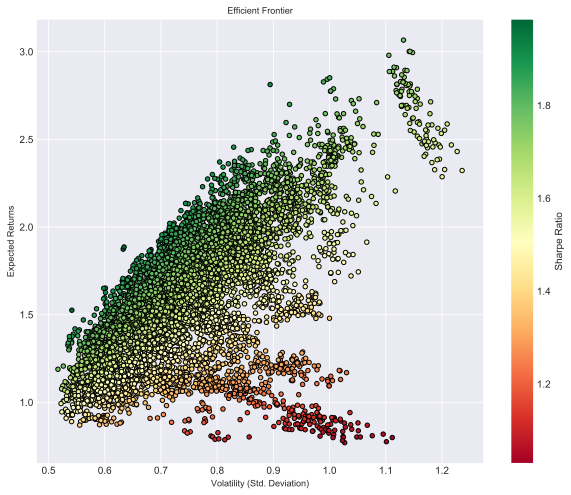

In [20]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

# Оптимальное соотношение активов

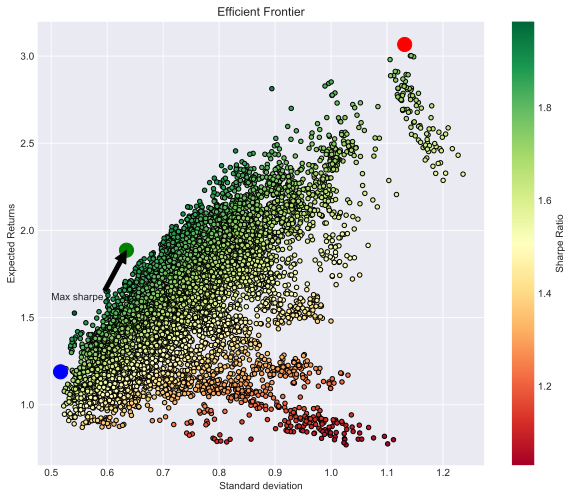

In [21]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_portfolio = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_portfolio['Volatility'], y=max_return_portfolio['Returns'], c='red', marker='o', s=200 )

plt.annotate('Max sharpe', xy=(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns']), xytext=(0.5, 1.6), 
             arrowprops=dict(facecolor='black', shrink=0.01))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [22]:
good_sharpe_portfolios = df.loc[df['Sharpe Ratio'] > 1.6]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Returns'] > 1.1]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['Volatility'] < 0.629939]
good_sharpe_portfolios = good_sharpe_portfolios.loc[good_sharpe_portfolios['BTC Weight'] > 0.4]
good_sharpe_portfolios['Cash'] = 1 - good_sharpe_portfolios['BTC Weight'] - good_sharpe_portfolios['ETH Weight'] - good_sharpe_portfolios['LTC Weight']
good_sharpe_portfolios

Returns  Volatility  Sharpe Ratio  BTC Weight  ETH Weight  LTC Weight  \
1562  1.255359    0.622649      1.617781    0.711736    0.098074    0.130190   
1711  1.244395    0.623652      1.608324    0.691322    0.103861    0.144816   
1803  1.249333    0.615209      1.625602    0.695366    0.120490    0.114143   
1824  1.247734    0.615501      1.623972    0.697026    0.119714    0.113260   
2160  1.359613    0.627823      1.681318    0.691598    0.208310    0.020092   
2188  1.374217    0.629607      1.688397    0.721736    0.170130    0.028134   
2275  1.266964    0.608200      1.649961    0.715904    0.129547    0.074548   
2442  1.210461    0.611087      1.604500    0.651068    0.105008    0.153924   
2459  1.253582    0.608500      1.639724    0.704615    0.115640    0.089745   
2555  1.241631    0.606570      1.634431    0.677097    0.132846    0.100057   
2630  1.345856    0.625486      1.676292    0.658420    0.150875    0.100705   
2792  1.389892    0.619209      1.717419    0.620232    0.184432    0.095336   
2995  1.382721    0.616592      1.716450    0.588453    0.219407    0.092140   
2999  1.226067    0.602921      1.628799    0.731703    0.142697    0.025600   
3018  1.209665    0.604600      1.613990    0.637378    0.110397    0.142224   
3063  1.334622    0.622972      1.672434    0.666356    0.205162    0.018482   
3067  1.363446    0.622546      1.693396    0.627295    0.176363    0.086342   
3122  1.379360    0.617391      1.713800    0.530624    0.167222    0.192154   
3143  1.353363    0.622638      1.685861    0.607661    0.225321    0.057018   
3177  1.250221    0.598017      1.655388    0.676480    0.132486    0.081033   
3208  1.381928    0.619245      1.711592    0.680300    0.160937    0.048763   
3215  1.358675    0.621342      1.692225    0.645014    0.173314    0.071672   
3219  1.374277    0.614581      1.715366    0.539607    0.166902    0.183490   
3300  1.216859    0.601242      1.624897    0.626839    0.117896    0.135265   
3398  1.211900    0.590055      1.640971    0.663620    0.147669    0.068711   
3439  1.410330    0.615379      1.736996    0.546337    0.240943    0.092720   
3443  1.469304    0.629363      1.751705    0.558090    0.183390    0.138520   
3444  1.258284    0.628179      1.611442    0.526647    0.113938    0.239415   
3446  1.327916    0.622154      1.669577    0.656734    0.182943    0.040323   
3503  1.242148    0.605289      1.636339    0.601357    0.116823    0.161819   
...        ...         ...           ...         ...         ...         ...   
7921  1.207853    0.550666      1.714723    0.426267    0.183793    0.119940   
7960  1.525939    0.606915      1.828202    0.405973    0.304029    0.019998   
7966  1.419068    0.547081      1.888835    0.486384    0.187404    0.056212   
7972  1.282251    0.574033      1.724074    0.414372    0.238995    0.076634   
7975  1.347063    0.541285      1.847204    0.409771    0.202477    0.117752   
8002  1.209225    0.554602      1.707628    0.440640    0.192594    0.096766   
8006  1.185487    0.540709      1.716926    0.531057    0.157715    0.041229   
8060  1.195783    0.546456      1.712902    0.556512    0.155290    0.018198   
8086  1.210416    0.559567      1.698536    0.424245    0.190407    0.115348   
8125  1.176428    0.544370      1.701037    0.543068    0.164295    0.012637   
8144  1.388737    0.543811      1.873494    0.415539    0.228586    0.075875   
8150  1.338724    0.541152      1.841216    0.413143    0.215614    0.091243   
8162  1.376227    0.542065      1.868137    0.406328    0.225923    0.087750   
8173  1.344506    0.565746      1.787905    0.486389    0.232396    0.001215   
8195  1.344472    0.571314      1.776460    0.445495    0.248123    0.026382   
8201  1.325732    0.534362      1.847399    0.431451    0.200325    0.088224   
8231  1.309540    0.537253      1.827443    0.441688    0.197157    0.081156   
8273  1.179955    0.550096      1.692934    0.409910    0.170809    0.139281   
8324  1

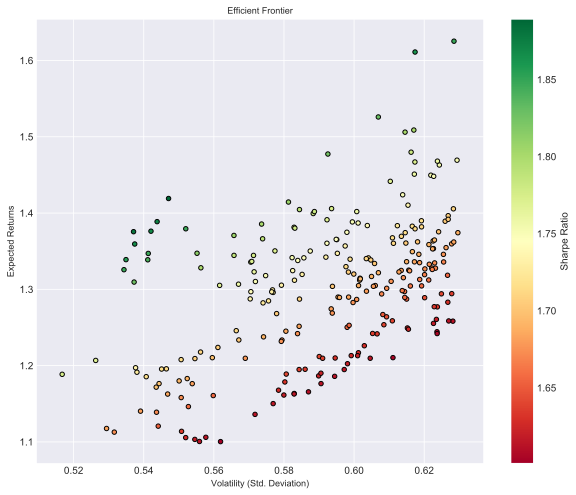

In [23]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
good_sharpe_portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

In [24]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)
print(max_return_portfolio.T)

                  8481
Returns       1.188619
Volatility    0.516737
Sharpe Ratio  1.774973
BTC Weight    0.465624
ETH Weight    0.186519
LTC Weight    0.057858
                  7485
Returns       1.886355
Volatility    0.634439
Sharpe Ratio  1.984620
BTC Weight    0.352433
ETH Weight    0.329924
LTC Weight    0.067643
                   867
Returns       3.066439
Volatility    1.131521
Sharpe Ratio  1.779954
BTC Weight    0.032794
ETH Weight    0.697248
LTC Weight    0.239958
